In [85]:
# Importo librerias necesarias
import warnings
warnings.filterwarnings("ignore")
import numpy as np # librería para poder usar arreglos
import pandas as pd # librería para poder usad DataFrames (tablas)
import plotly.express as px
import matplotlib.pyplot as plt # to plot
import seaborn as sns # to plot
import sklearn # librería para poder usar modelos de machine learning
import numpy as np
import pickle
import math as mth

In [86]:
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
import sklearn.decomposition as sk # to compute PCA
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn import svm
from sklearn.neural_network import MLPRegressor
from sklearn.datasets import make_regression


In [87]:
def get_data():
    """
    Funcion para obtener los datos del archivo covid.csv
    """

    dataSet = pd.read_csv("covid.csv", header=0)
    dataSet.set_index('date', inplace=True)
    dataSet.index = pd.to_datetime(dataSet.index,format='%d/%m/%y',errors='ignore')

    return dataSet

def infoData(dataSet):
    """
    Funcion para obtener datos generales
    """

    print(dataSet.head(10))
    print("")
    print(dataSet.info())
    print("")
    print(dataSet.isnull().sum())
    print("")

In [88]:
data = get_data()
infoData(data)


            AGUASCALIENTES  BAJA CALIFORNIA  BAJA CALIFORNIA SUR  CAMPECHE  \
date                                                                         
2020-02-26               0                0                    0         0   
2020-02-27               0                0                    0         0   
2020-02-28               0                0                    0         0   
2020-02-29               0                0                    0         0   
2020-03-01               0                0                    0         0   
2020-03-02               0                0                    0         0   
2020-03-03               0                0                    0         0   
2020-03-04               0                0                    0         0   
2020-03-05               0                0                    0         0   
2020-03-06               0                0                    0         0   

            CHIAPAS  CHIHUAHUA  DISTRITO FEDERAL  COAHUILA  COL

In [89]:
def preprocess_data(dataSet):
    """
    Funcion para el preprocesamiento de datos
    """

    local_dataSet = dataSet.dropna()
    columns_list = dataSet.columns.tolist()
    min_max_scaler = preprocessing.MinMaxScaler() # standardScaler
    min_max_scaler.fit(local_dataSet)
    new_dataSet = min_max_scaler.transform(local_dataSet)

    new_dataSet = pd.DataFrame(np.round(new_dataSet,4), columns=columns_list)
    new_dataSet.index = local_dataSet.index

    return new_dataSet

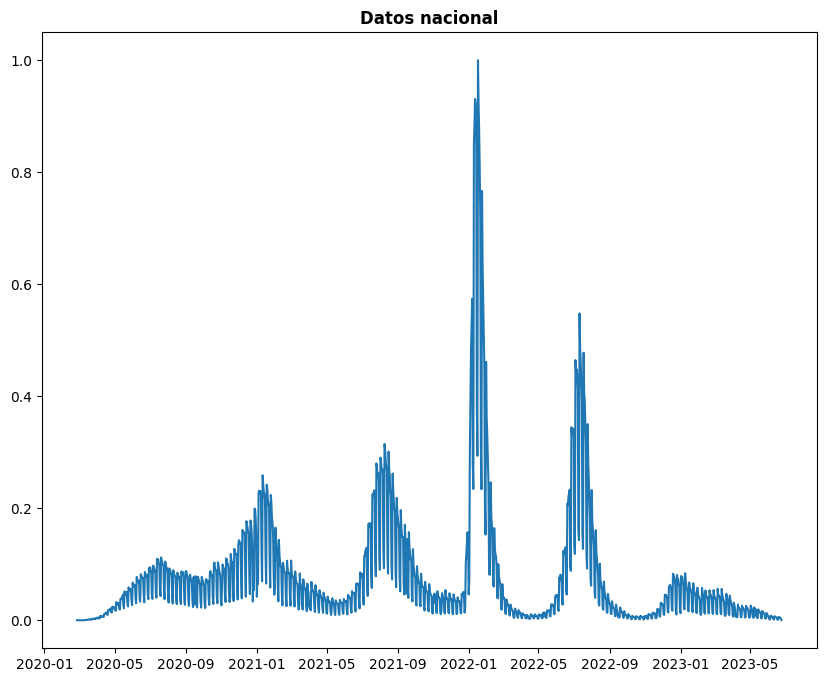

In [90]:
preprocessData = preprocess_data(data)

plt.figure(figsize=(10, 8))
plt.plot(preprocessData['Nacional'])
plt.title('Datos nacional', fontweight='bold')
plt.show()

In [91]:
def pca_Transformation(dataSet):
    features = dataSet
    features = features.drop(['Nacional'], axis=1)

    # principal components analysis
    pca = sk.PCA(n_components=3)
    principalComponents = pca.fit_transform(features)
    principalComp = pd.DataFrame(data = principalComponents,
                                 columns = ['P. Comp. 1', 'P. Comp. 2', 'P. Comp. 3'])
    principalComp.set_index(dataSet.index,inplace = True, drop=True)
    principalComp['Nacional'] = dataSet['Nacional']
    cols = principalComp.columns.tolist()
    cols = cols[-1:] + cols[:-1]
    principalComp = principalComp[cols]

    print("==========================================================")
    print("                 PCA ANALYSIS")
    print("----------------------------------------------------------")
    print(principalComp)
    print("\n")

    varRatio = (pca.explained_variance_ratio_)*100
    data = {'P. Comp. 1':varRatio[0],'P. Comp. 2':varRatio[1],'P. Comp. 3':varRatio[2]}
    dfVar = pd.DataFrame(data, index=['Exp Var Ratio %'])
    print(dfVar)
    print("\n")

    return principalComp

In [92]:
pcaData = pca_Transformation(preprocessData)
pcaData.head(1215)

                 PCA ANALYSIS
----------------------------------------------------------
            Nacional  P. Comp. 1  P. Comp. 2  P. Comp. 3
date                                                    
2020-02-26    0.0000   -0.420984   -0.025472   -0.013954
2020-02-27    0.0000   -0.420786   -0.025421   -0.013903
2020-02-28    0.0000   -0.420896   -0.025544   -0.013894
2020-02-29    0.0000   -0.420792   -0.025320   -0.014072
2020-03-01    0.0000   -0.420784   -0.025356   -0.013891
...              ...         ...         ...         ...
2023-06-20    0.0055   -0.385418   -0.023980   -0.031617
2023-06-21    0.0050   -0.389817   -0.025970   -0.026036
2023-06-22    0.0048   -0.394643   -0.029628   -0.022447
2023-06-23    0.0026   -0.401546   -0.021571   -0.028535
2023-06-24    0.0002   -0.419864   -0.024882   -0.014331

[1215 rows x 4 columns]


                 P. Comp. 1  P. Comp. 2  P. Comp. 3
Exp Var Ratio %   81.101835    5.824434    3.614026




,Nacional,P. Comp. 1,P. Comp. 2,P. Comp. 3
date,,,,
2020-02-26,0.0000,-0.420984,-0.025472,-0.013954
2020-02-27,0.0000,-0.420786,-0.025421,-0.013903
2020-02-28,0.0000,-0.420896,-0.025544,-0.013894
2020-02-29,0.0000,-0.420792,-0.025320,-0.014072
2020-03-01,0.0000,-0.420784,-0.025356,-0.013891
...,...,...,...,...
2023-06-20,0.0055,-0.385418,-0.023980,-0.031617
2023-06-21,0.0050,-0.389817,-0.025970,-0.026036
2023-06-22,0.0048,-0.394643,-0.029628,-0.022447


In [93]:
train_data, test_data = train_test_split(pcaData, test_size=0.25, shuffle=False) #Ya probé con 20, y 30
print(train_data.head(1215))
print("")
print(len(train_data))
print("")
print(test_data.head(1215))
print("")
print(len(test_data))

            Nacional  P. Comp. 1  P. Comp. 2  P. Comp. 3
date                                                    
2020-02-26    0.0000   -0.420984   -0.025472   -0.013954
2020-02-27    0.0000   -0.420786   -0.025421   -0.013903
2020-02-28    0.0000   -0.420896   -0.025544   -0.013894
2020-02-29    0.0000   -0.420792   -0.025320   -0.014072
2020-03-01    0.0000   -0.420784   -0.025356   -0.013891
...              ...         ...         ...         ...
2022-08-20    0.0210   -0.287385    0.002451    0.002460
2022-08-21    0.0187   -0.293690    0.000125    0.009103
2022-08-22    0.0691   -0.015549    0.005202    0.060701
2022-08-23    0.0507   -0.102404    0.010890    0.055541
2022-08-24    0.0462   -0.132828    0.019228    0.046232

[911 rows x 4 columns]

911

            Nacional  P. Comp. 1  P. Comp. 2  P. Comp. 3
date                                                    
2022-08-25    0.0404   -0.171591    0.015264    0.020806
2022-08-26    0.0362   -0.204175    0.005791    0.015538
2

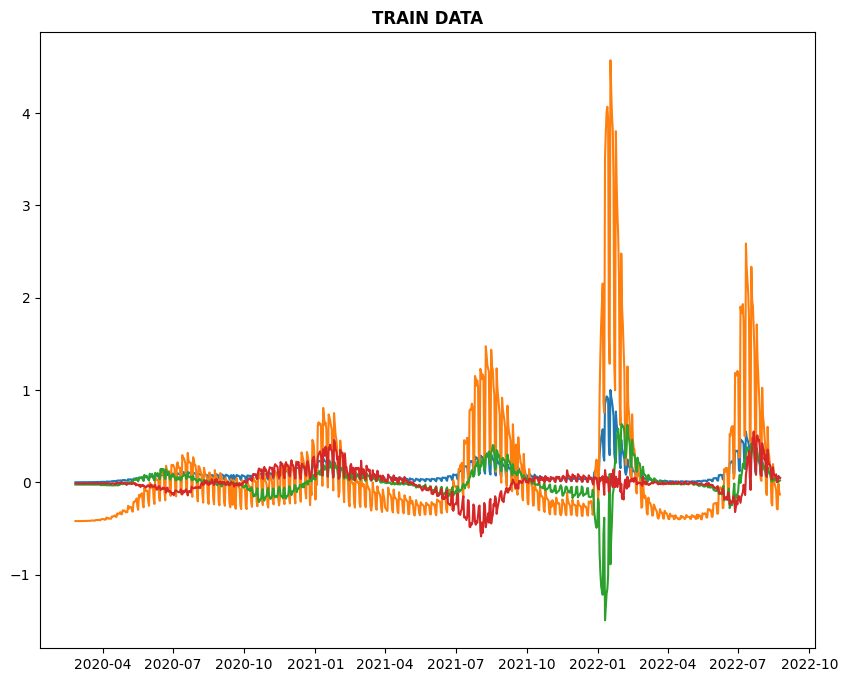

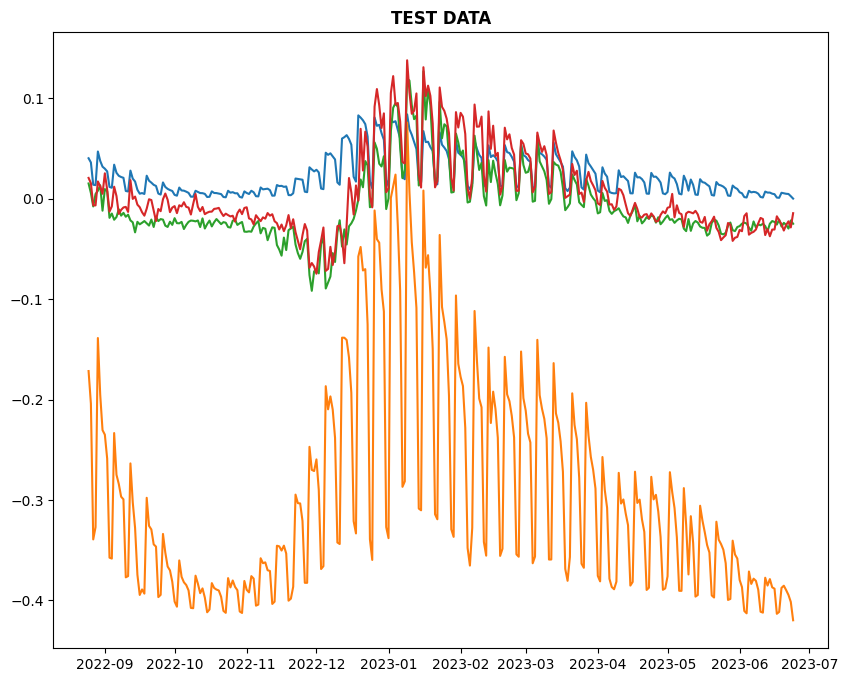

In [94]:
plt.figure(figsize=(10, 8))
plt.plot(train_data)
plt.title('TRAIN DATA', fontweight='bold')
plt.show()

plt.figure(figsize=(10, 8))
plt.plot(test_data)
plt.title('TEST DATA', fontweight='bold')
plt.show()

Modelado del PCA

In [95]:
class Model():
    def __init__(self,model):
        self.model = model
        self.training_data = None
        
    def load_training(self,training_data:pd.Series|list,Expected_results:pd.Series|list[int|float]):
        self.training_data = (training_data,Expected_results)

    def run_training(self):
        if self.training_data is None:
            raise ValueError("No hay datos de entrenamiento cargados. Usa load_training().")
            return False
        self.model.fit(self.training_data[0],self.training_data[1])
        return True
    
    def predict(self,data:pd.Series|list):
        return self.model.predict(data)

    def classification_test_accuracy(self,test_data:pd.Series|list,expected_results:pd.Series|list[int|float]):
        predictions = self.predict(test_data)
        expected_results = list(expected_results)
        results_compare = {"correc_pos":0,"correct_neg":0,"false_pos":0,"false_neg":0}

        for i in range(len(expected_results)):
            is_equal =(predictions[i] == expected_results[i])
            if(is_equal):
                if(predictions[1]):
                    results_compare["correc_pos"] += 1
                else:
                    results_compare["correct_neg"] += 1
            else:
                if(predictions[i]):
                    results_compare["false_pos"] += 1
                else:
                    results_compare["false_neg"] += 1
        
        evals = {"Acur":0,"Press":0,"TPR":0,"F1":0}
        correct = results_compare["correc_pos"]+results_compare["correct_neg"]
        total = len(expected_results)
        try:
            evals["Acur"] = correct/total
        except:
            pass
        try:
            evals["Press"] = results_compare["correc_pos"]/(results_compare["correc_pos"]+results_compare["false_pos"])
        except:
            pass
        try:
            evals["TPR"] = results_compare["correc_pos"]/(results_compare["correc_pos"]+results_compare["false_neg"])
        except:
            pass
        try:
            evals["F1"] = 2*evals["Press"]*evals["TPR"]/(evals["Press"]+evals["TPR"])
        except:
            pass

        
        return evals
    
    def regression_test_accuracy(self,test_data:pd.Series|list,expected_results:pd.Series|list[int|float],k:int|float):
        results = self.model.predict(test_data)
        expected_results = list(expected_results)
        mean = sum(expected_results)/len(expected_results)
        rss = 0
        ssr = 0
        mae = 0
        mape = 0
        for i in range(len(results)):
            rss += (expected_results[i]-results[i])**2
            ssr += (results[i]-mean)**2
            mae += abs(expected_results[i]-results[i]) 
            mape += abs((expected_results[i]-results[i])/expected_results[i])
        if (np.isnan(mape)):
            mape = 0
        tss = rss+ssr
        evaluations = {"TSS":tss,"RSS":rss,"SSR":ssr,"R2":0,"MSE":0,"RMSE":0,
                       "MAPE":0,"MAE":0,"AIC":0,"BIC":0,
                       "TIME SERIES R2":0,"APC":0}
        try:
            evaluations["R2"] = 1-(rss/tss)
        except:
            evaluations["R2"] = np.nan
        try:
            evaluations["MSE"] = rss/len(expected_results)
        except:
            evaluations["MSE"] = np.nan
        try:
            evaluations["MAPE"] = mape*100/len(expected_results)
        except:
            evaluations["MAPE"] = np.nan
        try:
            evaluations["MAE"] = mae/len(expected_results)
        except:
            evaluations["MAE"] = np.nan
        try:
            evaluations["AIC"] = -2*mth.log(rss/len(expected_results))+2*(k)
        except:
            evaluations["AIC"] = np.nan
        try:
            evaluations["BIC"] = (k)*mth.log(len(expected_results))-len(expected_results)*mth.log(rss/len(expected_results))
        except:
            evaluations["BIC"] = np.nan
        try:
            evaluations["APC"] = mth.sqrt(rss)+2*(k)/len(expected_results)
        except:
            evaluations["APC"] = np.nan
        try:
            evaluations["TIME SERIES R2"] = 1-((1-evaluations["R2"])*(len(expected_results)-1)/(len(expected_results)-1-test_data.shape[1]))
        except:
            evaluations["TIME SERIES R2"] = np.nan
        try:
            evaluations["RMSE"] = mth.sqrt(evaluations["MSE"])
        except:
            evaluations["RMSE"] = np.nan
        return evaluations

In [51]:
# === Definición de variables (X e Y) Train y Test===
X_train = train_data[['P. Comp. 1', 'P. Comp. 2', 'P. Comp. 3']]  # Características
Y_train = train_data[['Nacional']]  # Objetivo
X_test = test_data[['P. Comp. 1', 'P. Comp. 2', 'P. Comp. 3']]  # Características
Y_test = test_data[['Nacional']]  # Objetivo

# Definición de variables globales (todos los modelos usan el mismo) para evaluación para Train y Test
n_train = len(Y_train["Nacional"])
print("Número de observaciones (n):", n_train)
p_train = len(X_train.columns)  # Número de variables independientes (componentes principales)
print("Número de variables independientes (p):", p_train)
n_test = len(Y_train["Nacional"])
print("Número de observaciones (n):", n_test)
p_test = len(X_train.columns)  # Número de variables independientes (componentes principales)
print("Número de variables independientes (p):", p_test)

Número de observaciones (n): 911
Número de variables independientes (p): 3
Número de observaciones (n): 911
Número de variables independientes (p): 3


In [52]:
# Decision Tree Regressor
dt_regr = DecisionTreeRegressor()
param_search_dt_regr = {
    'criterion': ['squared_error', 'absolute_error', 'poisson'],
    'max_depth': [3, 5, 7, 9, 15, 20, None]
}

# Utilizo GridSearchCV para encontrar los mejores parámetros
# Definir X (característica) y y (objetivo)
X = train_data[['P. Comp. 1', 'P. Comp. 2', 'P. Comp. 3']]
y = train_data[['Nacional']]

grid_search_dt = GridSearchCV(estimator=dt_regr, param_grid=param_search_dt_regr, n_jobs=-1, cv=5, verbose=1)
grid_search_dt.fit(X, y)  # Entreno el modelo con los componentes principales como característica y la columna 'Nacional' como objetivo
best_params_dt = grid_search_dt.best_params_

print("==========================================================")
print("Mejores parámetros para Decision Tree Regressor:")
print(best_params_dt)
print("----------------------------------------------------------")

Fitting 5 folds for each of 21 candidates, totalling 105 fits
Mejores parámetros para Decision Tree Regressor:
{'criterion': 'absolute_error', 'max_depth': None}
----------------------------------------------------------


In [53]:
dt_optimo = grid_search_dt.best_estimator_
dt_optimo.fit(X_train, Y_train)

# === Predicciones ===
train_pred_dt = dt_optimo.predict(X_train)  # Predecir 'Nacional' para train
test_pred_dt = dt_optimo.predict(X_test)    # Predecir 'Nacional' para test

# === Convertir a DataFrames para análisis ===
pred_train_df_dt = pd.DataFrame(train_pred_dt, columns=["Nacional"], index=X_train.index)
pred_test_df_dt = pd.DataFrame(test_pred_dt, columns=["Nacional"], index=X_test.index)

pred_train_df_dt.columns = ["Nacional"]
pred_test_df_dt.columns = ["Nacional"]


# Datos de mi arbol de decisión
n_leaves_dt = dt_optimo.tree_.n_leaves
n_nodes_dt = dt_optimo.tree_.node_count

print(f"Número de hojas (leaves): {n_leaves_dt}")
print(f"Número total de nodos: {n_nodes_dt}")
print(f"Profundidad del árbol: {dt_optimo.get_depth()}")

Número de hojas (leaves): 875
Número total de nodos: 1749
Profundidad del árbol: 21


In [104]:
# Suppose your dt model is called 'dt'
dt_model = Model(dt_optimo)

# Load training data (X_train, Y_train)
dt_model.load_training(X_train, Y_train["Nacional"])

# Train the model (if not already trained)
dt_model.run_training()

# Get predictions for train and test
train_pred_dt = dt_model.predict(X_train)
test_pred_dt = dt_model.predict(X_test)

k_dt = dt_optimo.tree_.node_count - n_leaves_dt # Estimación de k para DT, otorgada por el profesor
# Evaluate metrics for train and test
train_metrics_dt = dt_model.regression_test_accuracy(X_train, Y_train["Nacional"], k=k_dt)
test_metrics_dt = dt_model.regression_test_accuracy(X_test, Y_test["Nacional"], k=k_dt)

print("Train metrics:", train_metrics_dt)
print("Test metrics:", test_metrics_dt)    

Train metrics: {'TSS': np.float64(14.865980906915464), 'RSS': np.float64(0.0), 'SSR': np.float64(14.865980906915464), 'R2': np.float64(1.0), 'MSE': np.float64(0.0), 'RMSE': 0.0, 'MAPE': 0.0, 'MAE': np.float64(0.0), 'AIC': nan, 'BIC': nan, 'TIME SERIES R2': np.float64(1.0), 'APC': np.float64(1.9187705817782656)}
Test metrics: {'TSS': np.float64(0.14020966759868403), 'RSS': np.float64(0.01017611999999999), 'SSR': np.float64(0.13003354759868405), 'R2': np.float64(0.9274221230655317), 'MSE': np.float64(3.347407894736839e-05), 'RMSE': 0.005785678780175096, 'MAPE': np.float64(16.793724738851218), 'MAE': np.float64(0.003357236842105259), 'AIC': np.float64(1768.6094783628146), 'BIC': np.float64(8129.322922176855), 'TIME SERIES R2': np.float64(0.9266963442961871), 'APC': np.float64(5.850876756490283)}


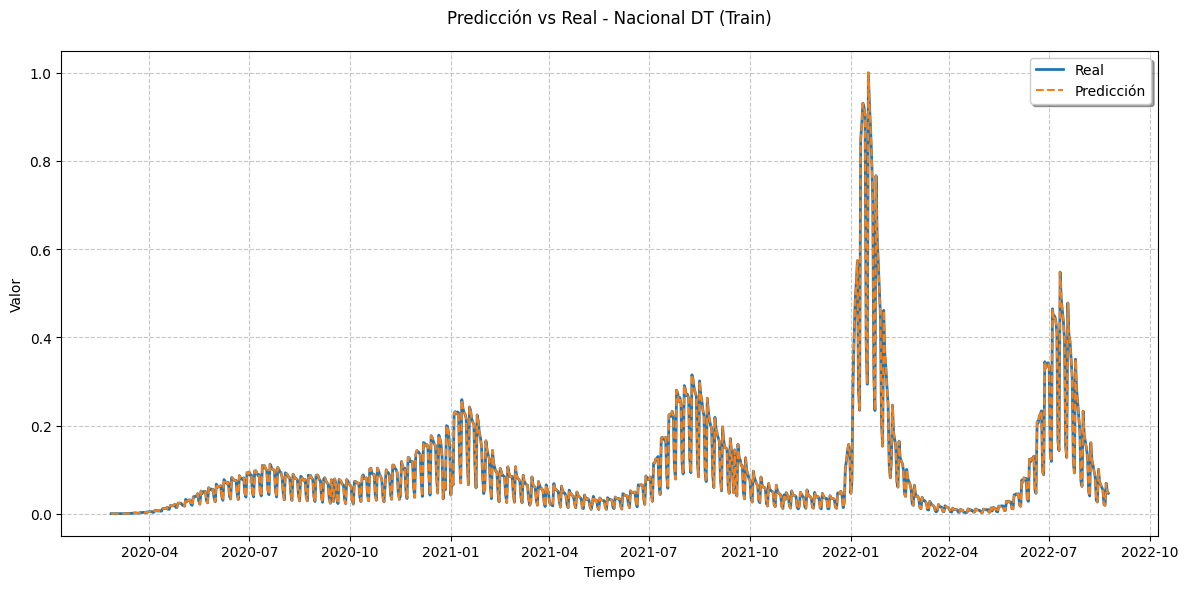

In [56]:
#Grafica de la predicción vs real DT
plt.figure(figsize=(12, 6))  
plt.plot(Y_train.index, Y_train.values, label="Real", linewidth=2)  
plt.plot(pred_train_df_dt.index, pred_train_df_dt.values, label="Predicción", linestyle="--")  
plt.title("Predicción vs Real - Nacional DT (Train)", fontsize=12, pad=20)
plt.xlabel("Tiempo", fontsize=10)
plt.ylabel("Valor", fontsize=10)
plt.legend(frameon=True, fancybox=True, shadow=True)
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

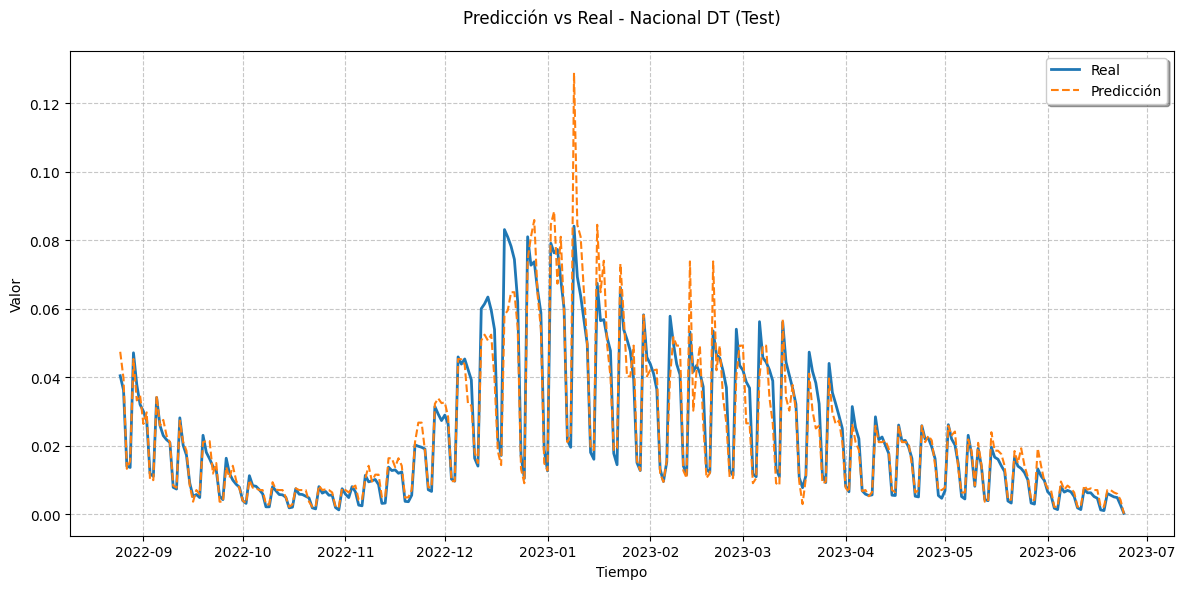

In [57]:
#Grafica de la predicción vs real DT
plt.figure(figsize=(12, 6))  
plt.plot(Y_test.index, Y_test.values, label="Real", linewidth=2)  
plt.plot(pred_test_df_dt.index, pred_test_df_dt.values, label="Predicción", linestyle="--")  
plt.title("Predicción vs Real - Nacional DT (Test)", fontsize=12, pad=20)
plt.xlabel("Tiempo", fontsize=10)
plt.ylabel("Valor", fontsize=10)
plt.legend(frameon=True, fancybox=True, shadow=True)
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

In [58]:
# Random forest
rf_regr = RandomForestRegressor()
param_search_rf_regr = {
    'criterion': ['squared_error', 'absolute_error', 'poisson'], #Puedo añadir 'friedman_mse',
    'n_estimators': [10, 50, 100, 200, None], # Puedo probar con [10, 50, 100, 200, 500]
    'max_depth': [3, 5, 7, 9, 15, 20, None]
}

# Utilizo GridSearchCV para encontrar los mejores parámetros
# Definir X (característica) y y (objetivo)
X = train_data[['P. Comp. 1', 'P. Comp. 2', 'P. Comp. 3']]
y = train_data[['Nacional']]

grid_search_rf = GridSearchCV(estimator=rf_regr, param_grid=param_search_rf_regr, n_jobs=-1, cv=5, verbose=1)
grid_search_rf.fit(X, y)  # Entreno el modelo con la columna 'Nacional' como característica y los componentes principales como objetivo
best_params_rf = grid_search_rf.best_params_

print("==========================================================")
print("Mejores parámetros para Decision Tree Regressor:")
print(best_params_rf)
print("----------------------------------------------------------")

Fitting 5 folds for each of 105 candidates, totalling 525 fits
Mejores parámetros para Decision Tree Regressor:
{'criterion': 'poisson', 'max_depth': 7, 'n_estimators': 10}
----------------------------------------------------------


In [59]:
rf_optimo = grid_search_rf.best_estimator_
# === Ajustar el modelo RF con los datos de entrenamiento ===
rf_optimo.fit(X_train, Y_train)

# === Predicciones ===
train_pred_rf = rf_optimo.predict(X_train)  # Predecir 'Nacional' para train
test_pred_rf = rf_optimo.predict(X_test)    # Predecir 'Nacional' para test

# === Convertir a DataFrames para análisis ===
pred_train_df_rf = pd.DataFrame(train_pred_rf, columns=["Nacional"], index=X_train.index)
pred_test_df_rf = pd.DataFrame(test_pred_rf, columns=["Nacional"], index=X_test.index)

pred_train_df_rf.columns = ["Nacional"]
pred_test_df_rf.columns = ["Nacional"]

# Calcular estadísticas de los árboles individuales en el Random Forest
n_leaves_rf = [est.tree_.n_leaves for est in rf_optimo.estimators_]
n_nodes_rf = [est.tree_.node_count for est in rf_optimo.estimators_]
depths_rf = [est.get_depth() for est in rf_optimo.estimators_]

print(f"Número promedio de hojas (leaves): {np.mean(n_leaves_rf):.2f}")
print(f"Número promedio de nodos: {np.mean(n_nodes_rf):.2f}")
print(f"Profundidad promedio del árbol: {np.mean(depths_rf):.2f}")

Número promedio de hojas (leaves): 106.40
Número promedio de nodos: 211.80
Profundidad promedio del árbol: 7.00


In [105]:
rf_train_results = pd.DataFrame({
    "Real Nacional": train_data["Nacional"],
    "Pred. Nacional": pred_train_df_rf["Nacional"]
})
# Creo un dataframe con los resultados
rf_train_results["Residuals"] = rf_train_results["Real Nacional"] - rf_train_results["Pred. Nacional"]
# Residuos diferencia entre valor real y valor predicho (error del modelo).
rf_train_results["Rel. Error"] = (1 - (rf_train_results["Pred. Nacional"] / rf_train_results["Real Nacional"])).abs()
# Datos de prueba (test)
rf_test_pred = pred_test_df_rf["Nacional"]
rf_test_results = pd.DataFrame({
    "Real Nacional": test_data["Nacional"],
    "Pred. Nacional": rf_test_pred
})
rf_test_results["Residuals"] = rf_test_results["Real Nacional"] - rf_test_results["Pred. Nacional"]
rf_test_results["Rel. Error"] = (1 - (rf_test_results["Pred. Nacional"] / rf_test_results["Real Nacional"])).abs()

In [106]:
# Suppose your rf model is called 'rf'
rf_model = Model(rf_optimo)

# Load training data (X_train, Y_train)
rf_model.load_training(X_train, Y_train["Nacional"])

# Train the model (if not already trained)
rf_model.run_training()

# Get predictions for train and test
train_pred_rf = rf_model.predict(X_train)
test_pred_rf = rf_model.predict(X_test)

k_rf = sum([nodes - leaves for nodes, leaves in zip(n_nodes_rf, n_leaves_rf)]) # Estimación de k para Rf, adaptada a la que el profesor mencionó
# Evaluate metrics for train and test
train_metrics_rf = rf_model.regression_test_accuracy(X_train, Y_train["Nacional"], k=k_rf)
test_metrics_rf = rf_model.regression_test_accuracy(X_test, Y_test["Nacional"], k=k_rf)

print("Train metrics:", train_metrics_rf)
print("Test metrics:", test_metrics_rf)   

Train metrics: {'TSS': np.float64(14.76675554640583), 'RSS': np.float64(0.040245456837285504), 'SSR': np.float64(14.726510089568546), 'R2': np.float64(0.9972745904331651), 'MSE': np.float64(4.4177230337305714e-05), 'RMSE': 0.006646595394433583, 'MAPE': np.float64(inf), 'MAE': np.float64(0.003793956041122807), 'AIC': np.float64(2128.054602104712), 'BIC': np.float64(16317.39947240835), 'TIME SERIES R2': np.float64(0.9972655758480488), 'APC': np.float64(2.5145534280576194)}
Test metrics: {'TSS': np.float64(0.12085934142074983), 'RSS': np.float64(0.003538369960080519), 'SSR': np.float64(0.11732097146066932), 'R2': np.float64(0.9707232397720725), 'MSE': np.float64(1.1639374868685918e-05), 'RMSE': 0.0034116528059997425, 'MAPE': np.float64(13.460893130472638), 'MAE': np.float64(0.0021614478863424304), 'AIC': np.float64(2130.722233645085), 'BIC': np.float64(9479.526711335086), 'TIME SERIES R2': np.float64(0.9704304721697933), 'APC': np.float64(6.993694725562989)}


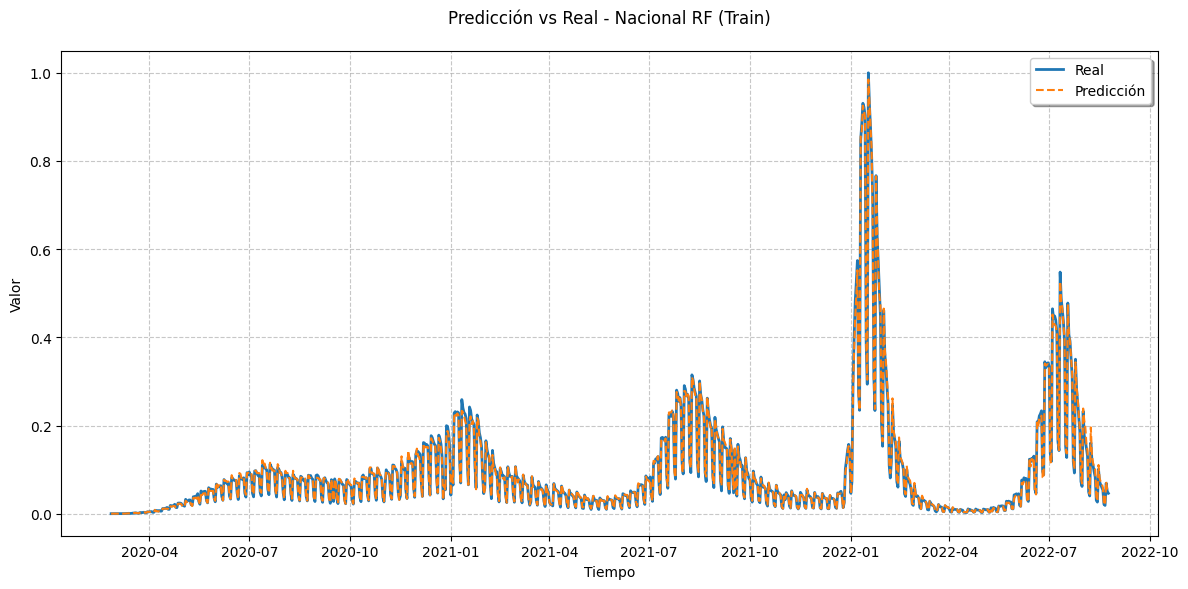

In [64]:
#Grafica de la predicción vs real RF Train
plt.figure(figsize=(12, 6))  
plt.plot(Y_train.index, Y_train.values, label="Real", linewidth=2)  
plt.plot(pred_train_df_rf.index, pred_train_df_rf.values, label="Predicción", linestyle="--")  
plt.title("Predicción vs Real - Nacional RF (Train)", fontsize=12, pad=20)
plt.xlabel("Tiempo", fontsize=10)
plt.ylabel("Valor", fontsize=10)
plt.legend(frameon=True, fancybox=True, shadow=True)
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

In [65]:
print(pred_test_df_rf.head(10))

            Nacional
date                
2022-08-25  0.044726
2022-08-26  0.037333
2022-08-27  0.014667
2022-08-28  0.015811
2022-08-29  0.048607
2022-08-30  0.037333
2022-08-31  0.035846
2022-09-01  0.032062
2022-09-02  0.029293
2022-09-03  0.009683


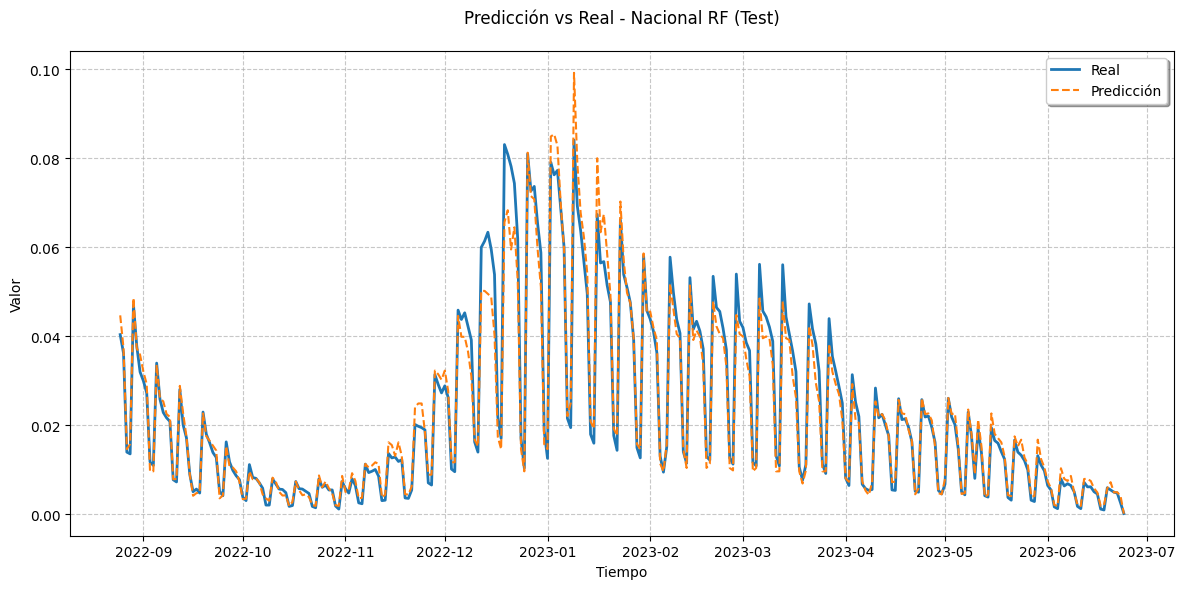

In [66]:
#Grafica de la predicción vs real RF Test
plt.figure(figsize=(12, 6))  
plt.plot(Y_test.index, Y_test.values, label="Real", linewidth=2)  
plt.plot(pred_test_df_rf.index, pred_test_df_rf.values, label="Predicción", linestyle="--")  
plt.title("Predicción vs Real - Nacional RF (Test)", fontsize=12, pad=20)
plt.xlabel("Tiempo", fontsize=10)
plt.ylabel("Valor", fontsize=10)
plt.legend(frameon=True, fancybox=True, shadow=True)
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

In [68]:
# Support Vector Machine
svm_regr = svm.SVR()
param_search_svm_regr = {
    'kernel': ['rbf', 'poly', 'sigmoid'],# , 'poly', 'rbf', 'sigmoid' linear
    'degree': [2, 3, 4, 5],  # 3, 4, 5, 6
    #'C': [0.1, 1, 10], # Puedo probar con [0.001, 0.01, 0.1, 1]
    'gamma': ['scale', 'auto'],
    'epsilon': [0.005, 0.05, 0.1, 0.2, 0.5],
    'max_iter': [-1]     # Número máximo de iteraciones
}

# Utilizo GridSearchCV para encontrar los mejores parámetros
# Definir X (característica) y Y (objetivo)
X = train_data[['P. Comp. 1', 'P. Comp. 2', 'P. Comp. 3']]
y = train_data[['Nacional']]

grid_search_svm = GridSearchCV(estimator=svm_regr, param_grid=param_search_svm_regr, n_jobs=-1, cv=5, verbose=1)
grid_search_svm.fit(X, y)  # Entreno el modelo con los componentes principales como característica y la columna 'Nacional' como objetivo
best_params_svm = grid_search_svm.best_params_

print("==========================================================")
print("Mejores parámetros para Support Vector Machine Regressor:")
print(best_params_svm)
print("----------------------------------------------------------")

Fitting 5 folds for each of 120 candidates, totalling 600 fits
Mejores parámetros para Support Vector Machine Regressor:
{'degree': 2, 'epsilon': 0.005, 'gamma': 'auto', 'kernel': 'rbf', 'max_iter': -1}
----------------------------------------------------------


In [69]:
svm_optimo = grid_search_svm.best_estimator_
# === Ajustar el modelo SVM con los datos de entrenamiento ===
svm_optimo.fit(X_train, Y_train)

# === Predicciones ===
train_pred_svm = svm_optimo.predict(X_train)  # Predecir 'Nacional' para train
test_pred_svm = svm_optimo.predict(X_test)    # Predecir 'Nacional' para test

# === Convertir a DataFrames para análisis ===
pred_train_df_svm = pd.DataFrame(train_pred_svm, columns=["Nacional"], index=X_train.index)
pred_test_df_svm = pd.DataFrame(test_pred_svm, columns=["Nacional"], index=X_test.index)

pred_train_df_svm.columns = ["Nacional"]
pred_test_df_svm.columns = ["Nacional"]

In [107]:
# Suppose your svm model is called 'svm'
svm_model = Model(svm_optimo)

# Load training data (X_train, Y_train)
svm_model.load_training(X_train, Y_train["Nacional"])

# Train the model (if not already trained)
svm_model.run_training()

# Get predictions for train and test
train_pred_svm = svm_model.predict(X_train)
test_pred_svm = svm_model.predict(X_test)

k_svm = len(svm_optimo.support_vectors_) # Estimación de k para SVM, otorgada por el profesor
# Evaluate metrics for train and test
train_metrics_svm = svm_model.regression_test_accuracy(X_train, Y_train["Nacional"], k=k_svm)
test_metrics_svm = svm_model.regression_test_accuracy(X_test, Y_test["Nacional"], k=k_svm)

print("Train metrics:", train_metrics_svm)
print("Test metrics:", test_metrics_svm)  

Train metrics: {'TSS': np.float64(14.755372095961423), 'RSS': np.float64(0.062173882623258354), 'SSR': np.float64(14.693198213338166), 'R2': np.float64(0.9957863561678478), 'MSE': np.float64(6.82479501901848e-05), 'RMSE': 0.008261231759863949, 'MAPE': np.float64(inf), 'MAE': np.float64(0.005298629512831529), 'AIC': 585.1847263163874, 'BIC': 10667.158477039007, 'TIME SERIES R2': np.float64(0.9957724190879179), 'APC': 0.8706421921113499}
Test metrics: {'TSS': np.float64(0.09818617778178937), 'RSS': np.float64(0.006522584834108625), 'SSR': np.float64(0.09166359294768074), 'R2': np.float64(0.9335692153267792), 'MSE': np.float64(2.1455871164831002e-05), 'RMSE': 0.004632048268836477, 'MAPE': np.float64(55.35672110036979), 'MAE': np.float64(0.0037655746575134853), 'AIC': 587.4990244721299, 'BIC': 4885.770559261706, 'TIME SERIES R2': np.float64(0.932904907480047), 'APC': 1.9426046264850008}


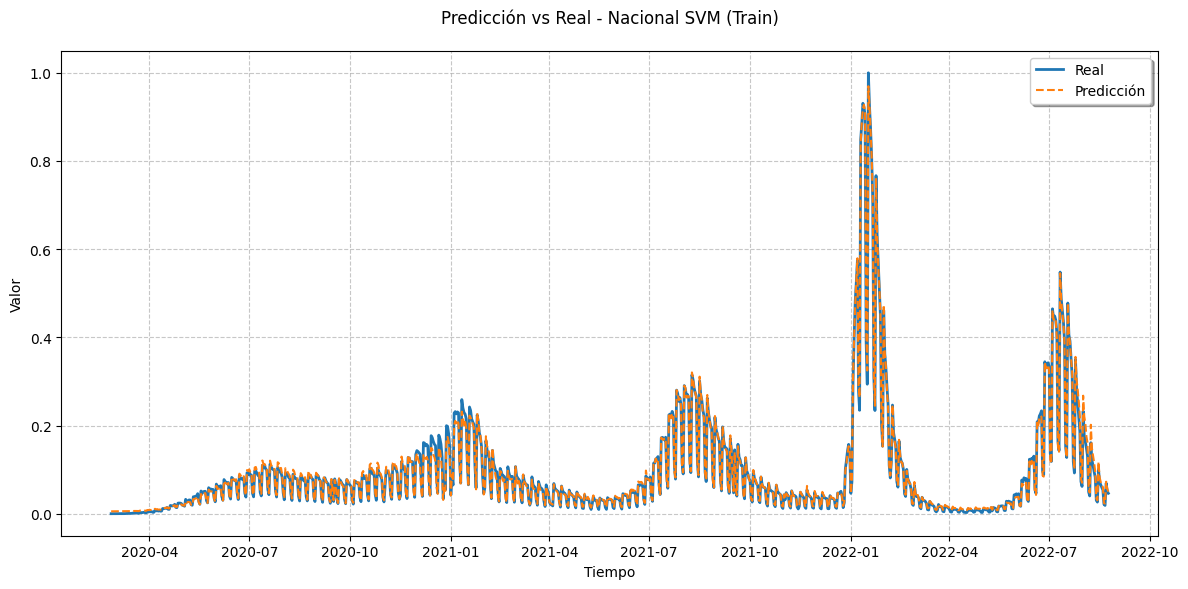

In [72]:
#Grafica de la predicción vs real SVM Train
plt.figure(figsize=(12, 6))  
plt.plot(Y_train.index, Y_train.values, label="Real", linewidth=2)  
plt.plot(pred_train_df_svm.index, pred_train_df_svm.values, label="Predicción", linestyle="--")  
plt.title("Predicción vs Real - Nacional SVM (Train)", fontsize=12, pad=20)
plt.xlabel("Tiempo", fontsize=10)
plt.ylabel("Valor", fontsize=10)
plt.legend(frameon=True, fancybox=True, shadow=True)
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

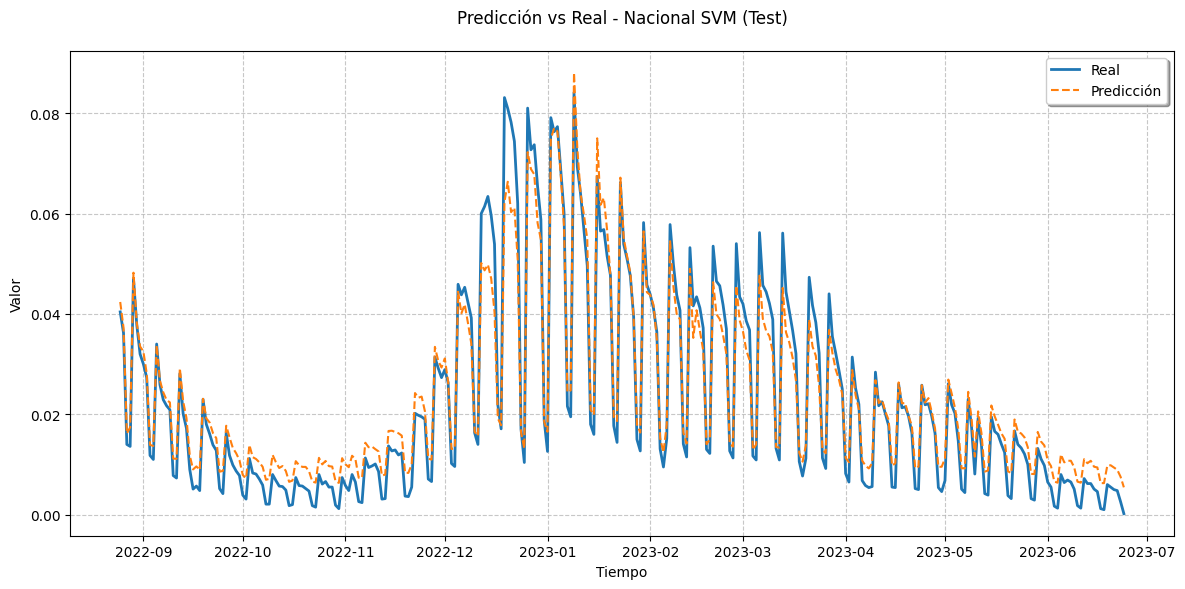

In [73]:
#Grafica de la predicción vs real SVM Test
plt.figure(figsize=(12, 6))  
plt.plot(Y_test.index, Y_test.values, label="Real", linewidth=2)  
plt.plot(pred_test_df_svm.index, pred_test_df_svm.values, label="Predicción", linestyle="--")  
plt.title("Predicción vs Real - Nacional SVM (Test)", fontsize=12, pad=20)
plt.xlabel("Tiempo", fontsize=10)
plt.ylabel("Valor", fontsize=10)
plt.legend(frameon=True, fancybox=True, shadow=True)
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

In [74]:

print(pred_test_df_svm.head(10))

            Nacional
date                
2022-08-25  0.042377
2022-08-26  0.037262
2022-08-27  0.016173
2022-08-28  0.017400
2022-08-29  0.048211
2022-08-30  0.038221
2022-08-31  0.033518
2022-09-01  0.032490
2022-09-02  0.028145
2022-09-03  0.013894


In [75]:
print(Y_test.head(10))

            Nacional
date                
2022-08-25    0.0404
2022-08-26    0.0362
2022-08-27    0.0140
2022-08-28    0.0136
2022-08-29    0.0471
2022-08-30    0.0378
2022-08-31    0.0320
2022-09-01    0.0300
2022-09-02    0.0273
2022-09-03    0.0118


In [96]:
# Multi-layer Perceptron Regressor
mlp_regr = MLPRegressor()
param_search_mlp_regr = {
    'random_state': [1, None],  # Fijo el estado aleatorio para reproducibilidad
    'max_iter': [1000, 2000, 3000],  # Puedo probar con [1000, 2000, 3000, 4000]
    'tol': [0.01, 0.1, 0.2],  # Puedo probar con [0.01, 0.05, 0.1, 0.2]
    'hidden_layer_sizes': [(50,), (100,), (150,), (200,)],  # Puedo probar con [(50,), (100,), (150,), (200,), (250,)]
    'learning_rate': ['constant', 'invscaling', 'adaptive'],  # Puedo probar con ['constant', 'invscaling', 'adaptive']
}

# Utilizo GridSearchCV para encontrar los mejores parámetros
# Definir X (característica) y y (objetivo)
X = train_data[['P. Comp. 1', 'P. Comp. 2', 'P. Comp. 3']]
y = train_data[['Nacional']]

# Le paso este objeto a la funcion de model_template y tambien le paso X Y
grid_search_mlp = GridSearchCV(estimator=mlp_regr, param_grid=param_search_mlp_regr, n_jobs=-1, cv=5, verbose=1)
grid_search_mlp.fit(X, y)  # Entreno el modelo con los componentes principales como característica y la columna 'Nacional' como objetivo
best_params_mlp = grid_search_mlp.best_params_

print("==========================================================")
print("Mejores parámetros para Multi-layer Perceptron Regressor:")
print(best_params_mlp)
print("----------------------------------------------------------")

Fitting 5 folds for each of 216 candidates, totalling 1080 fits
Mejores parámetros para Multi-layer Perceptron Regressor:
{'hidden_layer_sizes': (150,), 'learning_rate': 'constant', 'max_iter': 3000, 'random_state': None, 'tol': 0.2}
----------------------------------------------------------


In [97]:
mlp_optimo = grid_search_mlp.best_estimator_
# === Ajustar el modelo MLP con los datos de entrenamiento ===
mlp_optimo.fit(X_train, Y_train)

# === Predicciones ===
train_pred_mlp = mlp_optimo.predict(X_train)  # Predecir 'Nacional' para train
test_pred_mlp = mlp_optimo.predict(X_test)    # Predecir 'Nacional' para test

# === Convertir a DataFrames para análisis ===
pred_train_df_mlp = pd.DataFrame(train_pred_mlp, columns=["Nacional"], index=X_train.index)
pred_test_df_mlp = pd.DataFrame(test_pred_mlp, columns=["Nacional"], index=X_test.index)

pred_train_df_mlp.columns = ["Nacional"]
pred_test_df_mlp.columns = ["Nacional"]

# Función para analizar el tamaño de la red neuronal MLP para saber cuando mide su k
def analyze_network_size(mlp_model):
    """
    Analisis del tamaño de una red neuronal MLP y la categoriza en pequeña, mediana o grande.
    """
    # Get network parameters
    n_layers = len(mlp_model.coefs_)
    n_neurons = [layer.shape[0] for layer in mlp_model.coefs_]
    total_params = sum(layer.size for layer in mlp_model.coefs_)
    
    # Size categorization
    if total_params < 1000:
        size_category = "Pequeña"
    elif total_params < 100000:
        size_category = "Mediana"
    else:
        size_category = "Grande"
    
    print(f"Arquitectura de la Red Neuronal:")
    print(f"Número de capas: {n_layers}")
    print(f"Neuronas por capa: {n_neurons}")
    print(f"Total de parámetros: {total_params:,}")
    print(f"Categoría de la red en base a su tamaño: {size_category}")
    
# Use after training your model
analyze_network_size(mlp_optimo)

Arquitectura de la Red Neuronal:
Número de capas: 2
Neuronas por capa: [3, 150]
Total de parámetros: 600
Categoría de la red en base a su tamaño: Pequeña


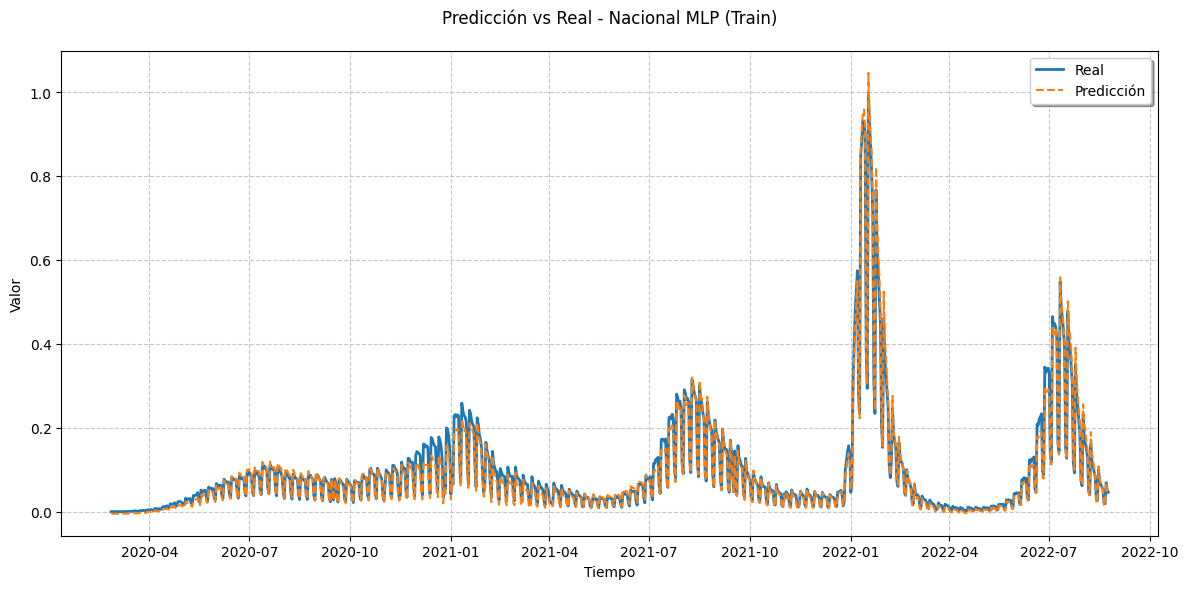

In [98]:
#Grafica de la predicción vs real MLP Train
plt.figure(figsize=(12, 6))  
plt.plot(Y_train.index, Y_train.values, label="Real", linewidth=2)  
plt.plot(pred_train_df_mlp.index, pred_train_df_mlp.values, label="Predicción", linestyle="--")  
plt.title("Predicción vs Real - Nacional MLP (Train)", fontsize=12, pad=20)
plt.xlabel("Tiempo", fontsize=10)
plt.ylabel("Valor", fontsize=10)
plt.legend(frameon=True, fancybox=True, shadow=True)
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

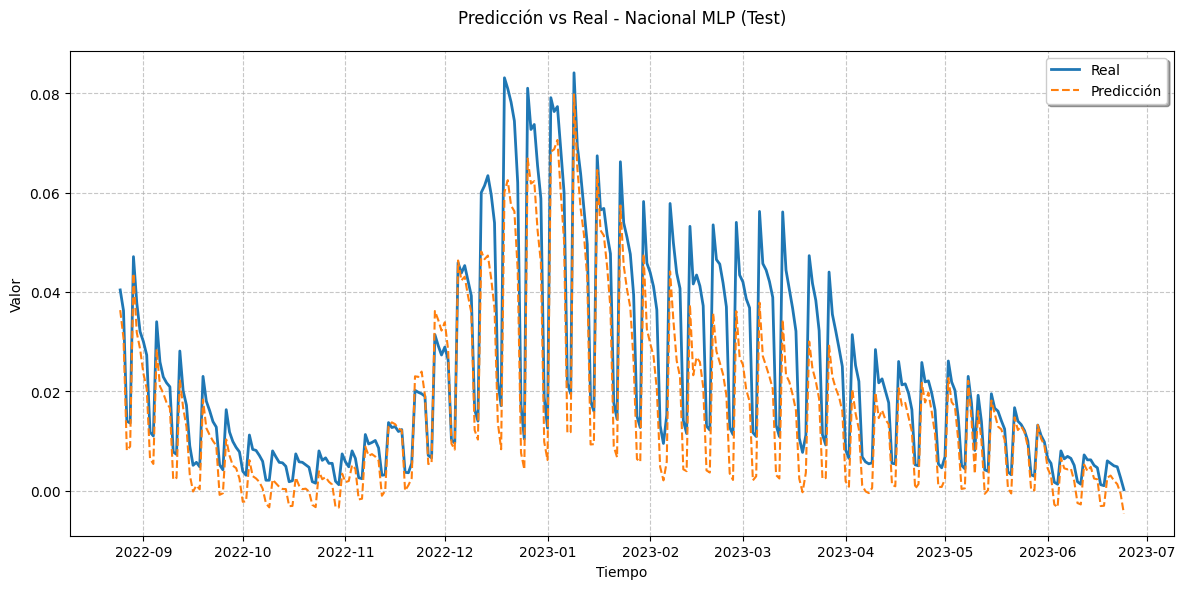

In [99]:
#Grafica de la predicción vs real MLP Test
plt.figure(figsize=(12, 6))  
plt.plot(Y_test.index, Y_test.values, label="Real", linewidth=2)  
plt.plot(pred_test_df_mlp.index, pred_test_df_mlp.values, label="Predicción", linestyle="--")  
plt.title("Predicción vs Real - Nacional MLP (Test)", fontsize=12, pad=20)
plt.xlabel("Tiempo", fontsize=10)
plt.ylabel("Valor", fontsize=10)
plt.legend(frameon=True, fancybox=True, shadow=True)
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

In [ ]:
# Suppose your MLP model is called 'mlp'
mlp_model = Model(mlp_optimo)

# Load training data (X_train, Y_train)
mlp_model.load_training(X_train, Y_train["Nacional"])

# Train the model (if not already trained)
mlp_model.run_training()

# Get predictions for train and test
train_pred_mlp = mlp_model.predict(X_train)
test_pred_mlp = mlp_model.predict(X_test)

# Red pequeña: k≈50, Red mediana: k≈100–200, Red grande: k>500
# Evaluate metrics for train and test
train_metrics_mlp = mlp_model.regression_test_accuracy(X_train, Y_train["Nacional"], k=50)
test_metrics_mlp = mlp_model.regression_test_accuracy(X_test, Y_test["Nacional"], k=50)

print("Train metrics:", train_metrics_mlp)
print("Test metrics:", test_metrics_mlp)            

Train metrics: {'TSS': np.float64(14.037677933406533), 'RSS': np.float64(0.14685597473898834), 'SSR': np.float64(13.890821958667544), 'R2': np.float64(0.9895384425091058), 'MSE': np.float64(0.00016120304581667216), 'RMSE': 0.012696576145428821, 'MAPE': np.float64(inf), 'MAE': np.float64(0.009038411436495282), 'AIC': 117.46569166685175, 'BIC': 8296.349699113973, 'TIME SERIES R2': np.float64(0.9895038397831161), 'APC': 0.4929874047747572}
Test metrics: {'TSS': np.float64(0.08716567339512679), 'RSS': np.float64(0.018216873840575697), 'SSR': np.float64(0.06894879955455109), 'R2': np.float64(0.7910086260907134), 'MSE': np.float64(5.9923927107156896e-05), 'RMSE': 0.0077410546508313, 'MAPE': np.float64(119.64106290857437), 'MAE': np.float64(0.007005154659186682), 'AIC': 119.4448693634628, 'BIC': 3241.471528316656, 'TIME SERIES R2': np.float64(0.7889187123516206), 'APC': 0.4639172681786493}


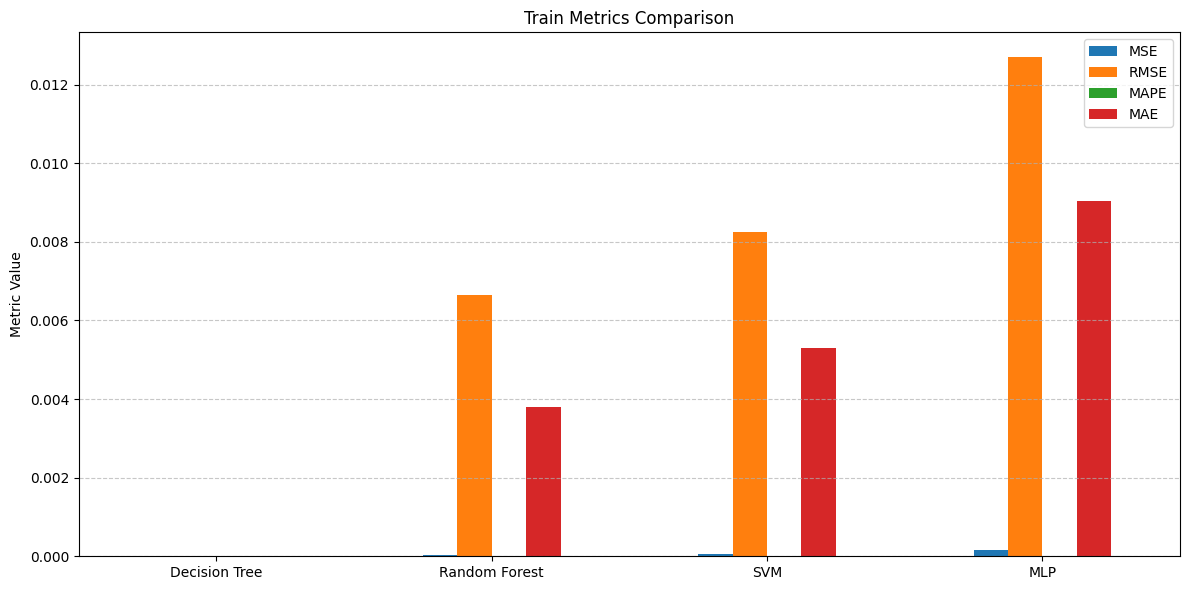

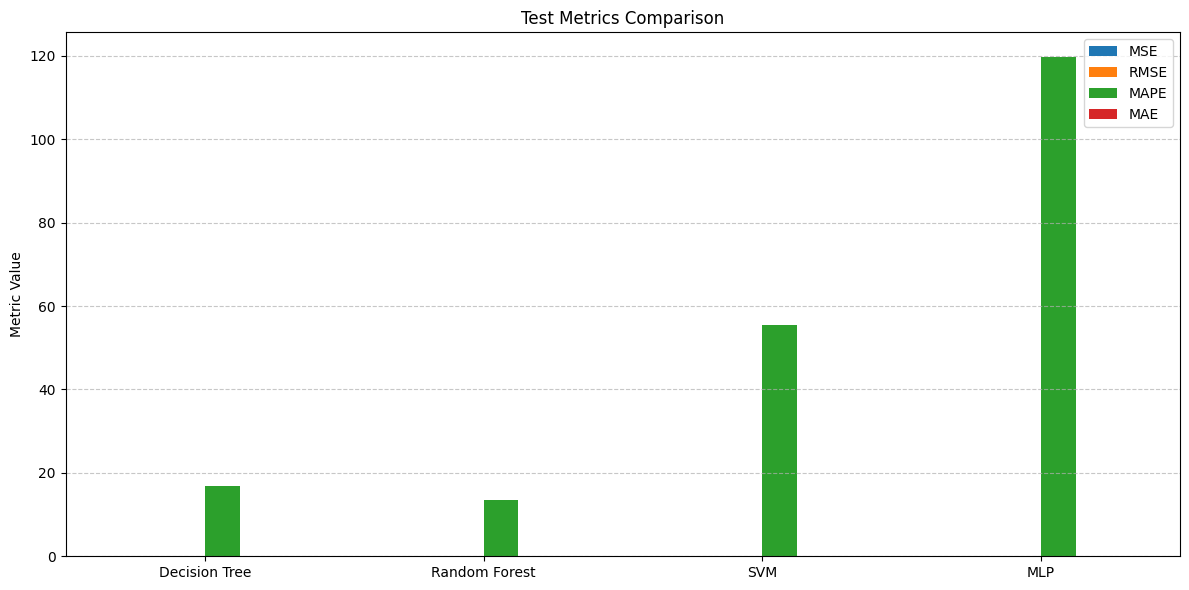

In [ ]:
# Prepare metrics for plotting
models = ['Decision Tree', 'Random Forest', 'SVM', 'MLP']
train_metrics_list = [train_metrics_dt, train_metrics_rf, train_metrics_svm, train_metrics_mlp]
test_metrics_list = [test_metrics_dt, test_metrics_rf, test_metrics_svm, test_metrics_mlp]

# Select metrics to compare
metrics_to_plot = ['MSE', 'RMSE', 'MAPE', 'MAE', 'R2', 'TSS', 'RSS', 'SSR', 'AIC', 'BIC', 'APC', 'TIME SERIES R2']

# Prepare data for train metrics
train_metrics_df = pd.DataFrame(
    {model: {metric: train_metrics[metric] for metric in metrics_to_plot} 
     for model, train_metrics in zip(models, train_metrics_list)}
).T

# Prepare data for test metrics
test_metrics_df = pd.DataFrame(
    {model: {metric: test_metrics[metric] for metric in metrics_to_plot} 
     for model, test_metrics in zip(models, test_metrics_list)}
).T

In [ ]:
   def save_model(self,path):
        if (path.split(".")[-1] != "pkl"):
            path = path+".pkl"
        with open(path,'wb') as f:
            pickle.dump(self.model,f)

    def load_model(self,path):
        with open(path, 'rb') as f:
            self.model = pickle.load(f)